In [63]:
from astropy import time
import numpy as np
from IPython import display
import pandas as pd
import panel as pn
pn.extension("tabulator")
import hvplot.pandas
import holoviews as hv

from lwautils import lwa_arx
from lwautils import TimeoutException
from lwa_antpos import reading, mapping
from mnc import mcs, common, ezdr
import dsautils.cnf as cnf
from lwa_f import snap2_fengine, snap2_feng_etcd_client
from lwa352_pipeline_control import Lwa352PipelineControl, Lwa352CorrelatorControl

In [64]:
# for debugging
#import etcd3
#from mnc.common import ETCD_HOST, ETCD_PORT
#client = etcd3.client(host=ETCD_HOST, port=ETCD_PORT)
#print(client.get('/mon/drvs2501/summary'))

## Set up

In [65]:
arxadrs = list(range(35, 46))  # currently installed
snap2names = ['snap09', 'snap10', 'snap11']
xhosts = [f'lxdlwagpu{i:02}' for i in range(1, 8)]
npipeline = 4  # x-eng
lwa_drc = ezdr.Lwa352RecorderControl('slow')
drids = lwa_drc.ids

# old way
#drips = ['10.41.0.25', '10.41.0.41']  # data recorder (two ips for lxdlwagpu09)
#dest_ip = list(sorted(drips*2))  # correlator -> data recorder (destination IPs)
#dest_port = [10001+i//npipeline for i in range(npipeline*len(xhosts))]  # correlator -> data recorder (destination ports)
#drroot = [f'drvs{ip.split(".")[-1]}' for ip in drips]  # data recorder root names
#drids = [f'{drr}{dp-10000:02}' for dp in set(dest_port) for drr in drroot]  # data recorder ids

Found 0 slow recorders: 


In [66]:
dd_statuses = []

## cnf

In [67]:
df_cnf_read = reading.read_antpos_etcd()
df_cnf = df_cnf_read[['snap2_hostname', 'snap2_chassis', 'snap2_location', 'fmc', 'pola_digitizer_channel',
                      'polb_digitizer_channel', 'arx_address', 'pola_arx_channel', 'polb_arx_channel',
                      'pola_fee', 'polb_fee']]

AttributeError: 'NoneType' object has no attribute 'decode'

In [45]:
#df_cnf

## ARX

In [46]:
ma = lwa_arx.ARX()
arxcfg = []
try:
    for adr in arxadrs:
        dds = ma.get_all_chan_cfg(adr)
        for ch, dd in enumerate(dds):
            dd['adr-ch'] = f'{adr}-{ch}'
            arxcfg.append(dd)
        dd_astatus = {'name': f'arx{adr}', 'mp_age': 0, 'ready': dd['sig_on']}
        dd_statuses.append(dd_astatus)
except:
    print('ARX timed out')
    dd_astatus = {'name': f'arx{adr}', 'mp_age': -1, 'ready': False}
    dd_statuses.append(dd_astatus)

df_arx = pd.DataFrame.from_dict(arxcfg)
if any(df_arx):
    df_arx.set_index('adr-ch', inplace=True)


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/lwautils/conf/etcdConfig.yml


In [47]:
#df_arx

## F-engine

In [48]:
# mp update cadence < 1 min

dd_fs = []
t_now = time.Time.now().unix
for snap2name in snap2names:
    snap2num = int(snap2name.lstrip('snap'))
    lwa_f = snap2_fengine.Snap2Fengine(snap2name)
    lwa_fe = snap2_feng_etcd_client.Snap2FengineEtcdClient(snap2name, snap2num)

    st, fl = lwa_f.fpga.get_status()
    t_now = time.Time.now().unix

    dd_fstatus = {'name': snap2name, 'mp_age': t_now-time.Time(st['timestamp']).unix,
              'ready': lwa_f.is_connected() and st['programmed']}
        
    dd_statuses.append(dd_fstatus)

    dd_f = {'name': snap2name}

    dd_f['is_connected'] = lwa_f.is_connected()  # can SNAP be reached with ping on network?
    dd_f['is_polling'] = lwa_fe.is_polling()   # is monitor service checking on SNAP?
    dd_f['programmed'] = st['programmed']
    dd_f['firmware'] = st['flash_firmware']
        
    dd_f['mp_age'] = t_now-time.Time(st['timestamp']).unix

    st, fl = lwa_f.sync.get_status()
    dd_f['uptime_fpga_clks'] = st['uptime_fpga_clks']

    st, fl = lwa_f.autocorr.get_status()
    dd_f['autocorr_acc_len'] = st['acc_len']

    st, fl = lwa_f.corr.get_status()
    dd_f['corr_acc_len'] = st['acc_len']

    st, fl = lwa_f.eqtvg.get_status()
    dd_f['tvg_enabled'] = st['tvg_enabled']

    st, fl = lwa_f.eq.get_status()
    dd_f['clip_count'] = st['clip_count']

    dd_fs.append(dd_f)
    
    st, fl = lwa_f.input.get_status()
    pows = np.array([v for (k,v) in st.items() if 'pow' in k])
    means = np.array([v for (k,v) in st.items() if 'mean' in k])
    rms = np.array([v for (k,v) in st.items() if 'rms' in k])
#    snap_input = [f'{snap2name}-{k.strip("rms")}' for (k,v) in st.items() if 'rms' in k]
    df_fstats = pd.DataFrame(data={'pows': pows, 'mean': means, 'snap': len(pows)*[f'{snap2name}']})

plot_fstats = df_fstats.hvplot.scatter('pows', 'mean', by='snap', width=500, title='F-engine stats')
df_f = pd.DataFrame.from_dict(dd_fs)
if any(df_f):
    df_f.set_index('name', inplace=True)

2021-11-19 19:46:46,254 - lwa_f.blocks.block:snap09 - WARNING -  - hostname (10.40.0.124) couldn't be turned into integer serial
2021-11-19 19:46:46,458 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 0
2021-11-19 19:46:46,626 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 1
2021-11-19 19:46:46,903 - lwa_f.blocks.block:snap09 - WARNING -  - hostname (10.40.0.124) couldn't be turned into integer serial
2021-11-19 19:46:47,088 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 0
2021-11-19 19:46:47,256 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 1


Triggering stats polling loop stop
Triggering stats polling loop stop
Trying to stop a non-existent command watch
Trying to stop a non-existent command watch


2021-11-19 19:46:47,723 - lwa_f.blocks.block:snap10 - WARNING -  - hostname (10.40.0.125) couldn't be turned into integer serial
2021-11-19 19:46:47,904 - lwa_f.blocks.block:snap10 - INFO - adc - Detected FMC ADC board on port 0
2021-11-19 19:46:48,083 - lwa_f.blocks.block:snap10 - INFO - adc - Detected FMC ADC board on port 1
2021-11-19 19:46:48,362 - lwa_f.blocks.block:snap10 - WARNING -  - hostname (10.40.0.125) couldn't be turned into integer serial
2021-11-19 19:46:48,541 - lwa_f.blocks.block:snap10 - INFO - adc - Detected FMC ADC board on port 0
2021-11-19 19:46:48,723 - lwa_f.blocks.block:snap10 - INFO - adc - Detected FMC ADC board on port 1


Triggering stats polling loop stop
Triggering stats polling loop stop
Trying to stop a non-existent command watch
Trying to stop a non-existent command watch


2021-11-19 19:46:49,190 - lwa_f.blocks.block:snap11 - WARNING -  - hostname (10.40.0.126) couldn't be turned into integer serial
2021-11-19 19:46:49,365 - lwa_f.blocks.block:snap11 - INFO - adc - Detected FMC ADC board on port 0
2021-11-19 19:46:49,541 - lwa_f.blocks.block:snap11 - INFO - adc - Detected FMC ADC board on port 1
2021-11-19 19:46:49,819 - lwa_f.blocks.block:snap11 - WARNING -  - hostname (10.40.0.126) couldn't be turned into integer serial
2021-11-19 19:46:49,993 - lwa_f.blocks.block:snap11 - INFO - adc - Detected FMC ADC board on port 0
2021-11-19 19:46:50,167 - lwa_f.blocks.block:snap11 - INFO - adc - Detected FMC ADC board on port 1


Triggering stats polling loop stop
Trying to stop a non-existent command watch


In [49]:
#df_f

In [50]:
#plot_fstats

## X-engine

In [51]:
# mp update cadence of <10s

dd_xs = []
t_now = time.Time.now().unix
for host in xhosts:
    for pipeline in range(npipeline):
        lwa_x = Lwa352PipelineControl(pipeline_id=pipeline, etcdhost=common.ETCD_HOST, host=host)
        if lwa_x.pipeline_is_up():
            st = lwa_x.corr.get_bifrost_status()
            t_now = time.Time.now().unix
            stats = st['stats']
            name = f'{host}-{pipeline}'
            dd_xstatus = {'name': name}
            dd_x = {'name': name}
            dd_x['gbps'] = st['gbps']
            dd_x['mp_age'] = t_now-st['time']
#            print(name, dd_x['mp_age'])
            if len(stats) > 1:
                dd_x['curr_sample'] = stats['curr_sample']
                dd_x['state'] = stats['state']
                dd_xstatus['ready'] = stats['state'] == 'running'
            dd_xs.append(dd_x)

            dd_xstatus['mp_age'] = t_now-st['time']
            dd_statuses.append(dd_xstatus)
        else:
            print(f'Pipeline for {host}:{pipeline} is not up')

df_x = pd.DataFrame.from_dict(dd_xs)
if any(df_x):
    df_x.set_index('name', inplace=True)

## Data capture

In [52]:
dd_ds = []
t_now = time.Time.now().unix
data_baselines = None
data_spectra = None
for drid in drids:
    lwa_dr = mcs.Client(drid)
    if lwa_dr is not None and data_baselines is None:
        data_baselines = lwa_dr.read_monitor_point('diagnostics/baselines', id=drid).value
        data_spectra = lwa_dr.read_monitor_point('diagnostics/spectra', id=drid).value

    summary = lwa_dr.read_monitor_point('summary')
    if summary is None:
        continue
    t_mp = summary.timestamp
    dd_dstatus = {'name': drid, 'mp_age': t_now-t_mp,
                  'ready': summary.value == 'normal'}
    dd_statuses.append(dd_dstatus)

    rx_rate = lwa_dr.read_monitor_point('bifrost/rx_rate', id=drid).value or None
    rx_missing = lwa_dr.read_monitor_point('bifrost/rx_missing', id=drid).value
    pipeline_lag = lwa_dr.read_monitor_point('bifrost/pipeline_lag', id=drid).value
    dd_d = {'name': f'{drid}', 'rx_rate': rx_rate, 'rx_missing': rx_missing,
            'pipeline_lag': pipeline_lag, 'summary': summary.value}
    dd_ds.append(dd_d)
else:
    lwa_dr = None
        
df_d = pd.DataFrame.from_dict(dd_ds)
if any(df_d):
    df_d.set_index('name', inplace=True)
#df_d

In [53]:
if data_baselines is not None:
    pane_spectra = pn.pane.PNG(display.Image(mcs.ImageMonitorPoint._decode_image_data(data_spectra)), width=500)
    pane_baselines = pn.pane.PNG(display.Image(mcs.ImageMonitorPoint._decode_image_data(data_baselines)), width=500)
else:
    pane_spectra = pn.pane.PNG()
    pane_baselines = pn.pane.PNG()

In [54]:
df_status = pd.DataFrame.from_dict(dd_statuses)
df_status.set_index('name', inplace=True)
#df_x

In [55]:
lwa_dr

## Build dashboard

In [56]:
# coloring and filtering functions

frequencies = np.linspace(0, 196/2, 4096//8, endpoint=False)  # get_new_corr does 8-channel average

def filter_df(antpol):
    """ Given ant-pol string input, plot the snap2 f-engine autocorr
    """

#    return df_spec[colname].hvplot.line(title=f'autocorrelation spectrum', xlabel='channels', ylabel='amplitude')
    if not antpol:
        specs = {f'no ant': np.zeros(512), 'frequencies': frequencies}
        df_spec = pd.DataFrame.from_dict(specs)
        return df_spec.hvplot.line(x='frequencies', title=f'autocorrelation spectrum',
                                   xlabel='frequencies', ylabel='amplitude')
    
    numpol = antpol.upper().lstrip('LWA-')  # prep input
    num = numpol[:-1]
    pol = numpol[-1:]
    i = mapping.antpol_to_digitizer(f'LWA-{num}', pol)
    
    spec = lwa_f.corr.get_new_corr(int(i), int(i)).real  # 8-channel average, normalized by accumulated time/chans
    specs = {f'ant {i}': spec, 'frequencies': frequencies}
    df_spec = pd.DataFrame.from_dict(specs)
    return df_spec.hvplot.line(x='frequencies', y=f'ant {i}', title=f'autocorrelation spectrum',
                               xlabel='frequencies', ylabel='amplitude')

def color_bad(val):
    """
    Colors text red if bad.
    Made for status df, so False and mp_age > 100 are "bad"
    """
    color = 'red' if (val is False or val > 100) else 'black'
    return 'color: %s' % color

#col_filter = pn.widgets.TextInput(placeholder='Enter a f-eng input for snap01')
col_filter = pn.widgets.TextInput(placeholder='Plot f-eng for ant-pol name (e.g., 240a)')

In [57]:
# using Tabulator
df_status_pane = pn.widgets.Tabulator(df_status).style.applymap(color_bad)
df_cnf_pane = pn.widgets.Tabulator(df_cnf, layout='fit_data_table', pagination='remote', page_size=20)
df_f_pane = pn.widgets.Tabulator(df_f, layout='fit_data_table', pagination='remote', page_size=20)
df_x_pane = pn.widgets.Tabulator(df_x, layout='fit_data_table', pagination='remote', page_size=20)
df_arx_pane = pn.widgets.Tabulator(df_arx, layout='fit_data_table', pagination='remote', page_size=20)
df_d_pane = pn.widgets.Tabulator(df_d, layout='fit_data_table', pagination='remote', page_size=20)

#df_status_pane.add_filter(slider, 'mp_age')
#df_status_pane_sel = pn.Column(slider, df_status_pane)

In [58]:
dashboard_title = pn.panel('## OVRO-LWA dashboard')
header_table = pn.pane.Markdown('##Subsystem monitor points')
tabs = pn.Tabs(('Cabling', df_cnf_pane),
               ('ARX', df_arx_pane),
               ('F-engine', df_f_pane),
               ('X-engine', df_x_pane),
               ('Data recorder', df_d_pane))
header_f = pn.pane.Markdown('##F-engine plots')
plot_spec_pane = pn.Row(pn.panel(pn.bind(filter_df, col_filter)), pn.Column(col_filter))
header_dr = pn.pane.Markdown('##Data recorder plots')
plot_dr = pn.Row(pane_spectra, pane_baselines)
mini_dashboard = pn.Column(dashboard_title, df_status_pane, header_table, tabs, header_f,
                           plot_fstats, plot_spec_pane, header_dr, plot_dr)

Column
    [0] Markdown(str)
    [1] HTML(Styler)
    [2] Markdown(str)
    [3] Tabs
        [0] Tabulator(pagination='remote', value=         snap2_hostname  ...)
        [1] Tabulator(pagination='remote', value=        sig_on  ...)
        [2] Tabulator(pagination='remote', value=        is_connected  ...)
        [3] Tabulator(pagination='remote', value=              ...)
        [4] Tabulator(pagination='remote', value=              ...)
    [4] Markdown(str)
    [5] HoloViews(NdOverlay)
    [6] Row
        [0] ParamFunction(function)
        [1] Column
            [0] TextInput(placeholder='Plot f-eng for ant-pol na...)
    [7] Markdown(str)
    [8] Row
        [0] PNG(Image, width=500)
        [1] PNG(Image, width=500)
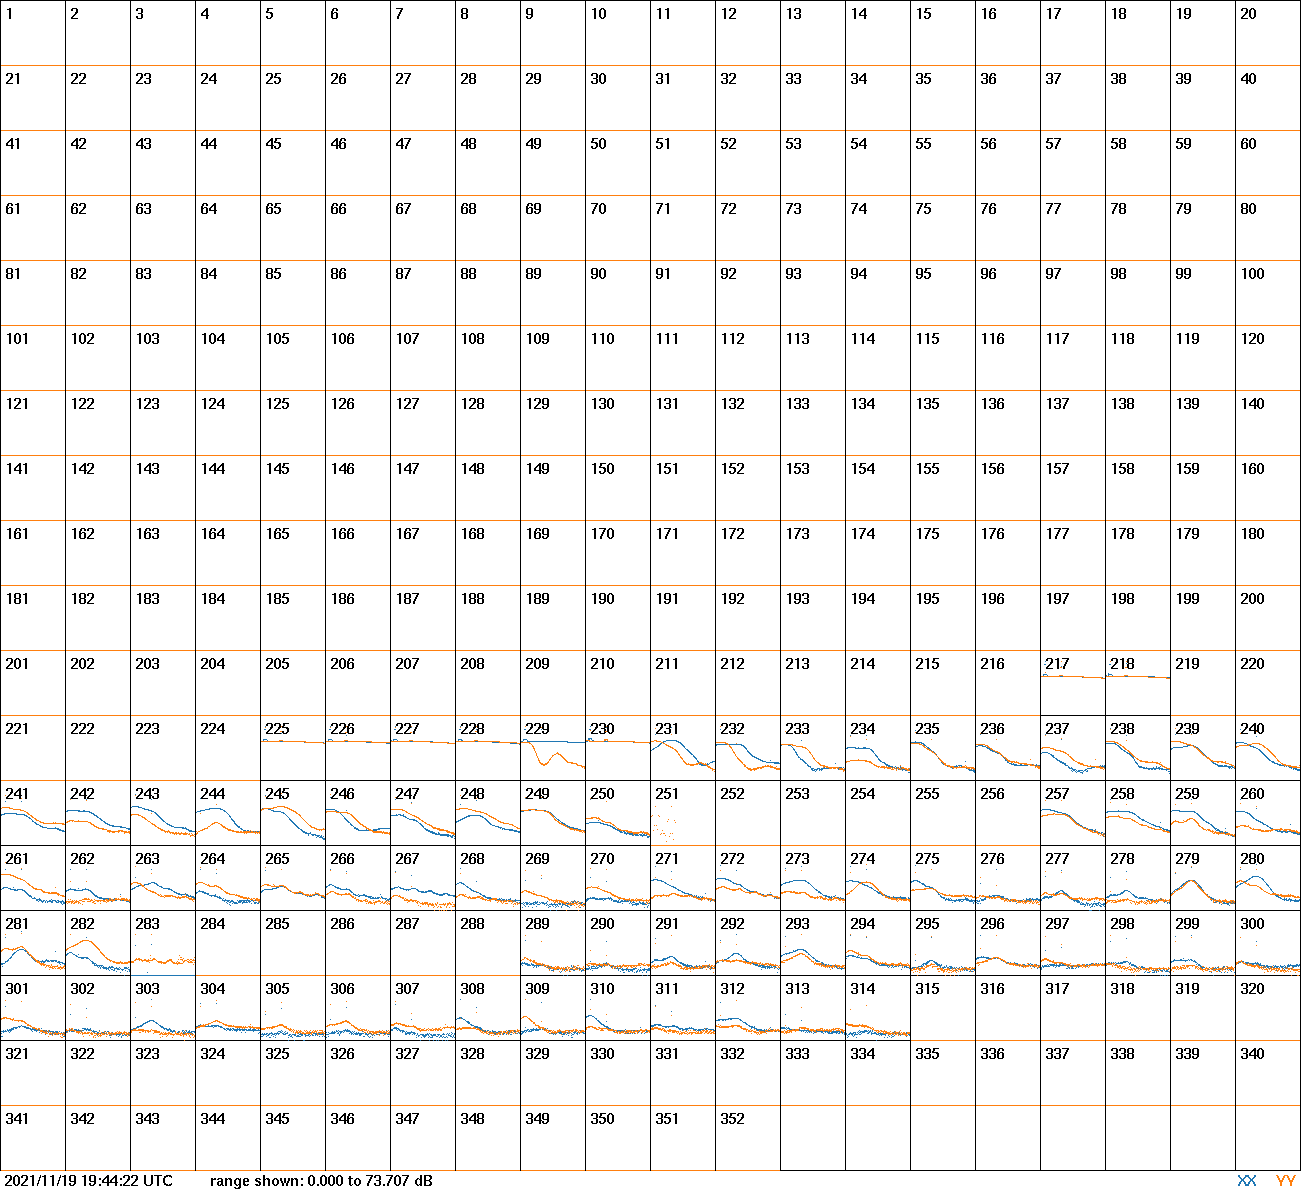
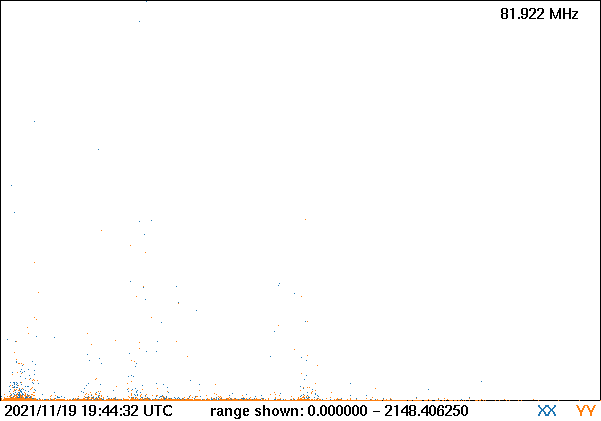

In [59]:
mini_dashboard.servable(title='OVRO-LWA dashboard')